# Data Wrangling, Cleaning and EDA for Seattle Public Library Collection

Dataset: The library collection catalogue for the entire Seattle Public Library system as of September 2017

Source: https://www.kaggle.com/seattle-public-library/seattle-library-checkout-records

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# style parameters
sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Data

In [2]:
# Load collection and Data dictionary
df = pd.read_csv('../../data/raw/Library_Collection_Inventory.csv')
df_dic = pd.read_csv('../../data/raw/Integrated_Library_System__ILS__Data_Dictionary.csv')

### Take a peak at the data

In [12]:
df.head(3)
# print(df.head(3))

,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
0,3011076,A tale of two friends / adapted by Ellie O'Rya...,"O'Ryan, Ellie","1481425730, 1481425749, 9781481425735, 9781481...",2014.,"Simon Spotlight,","Musicians Fiction, Bullfighters Fiction, Best ...",jcbk,ncrdr,Floating,qna,09/01/2017,1
1,2248846,"Naruto. Vol. 1, Uzumaki Naruto / story and art...","Kishimoto, Masashi, 1974-",1569319006,"2003, c1999.","Viz,","Ninja Japan Comic books strips etc, Comic book...",acbk,nycomic,NaN,lcy,09/01/2017,1
2,3209270,"Peace, love & Wi-Fi : a ZITS treasury / by Jer...","Scott, Jerry, 1955-","144945867X, 9781449458676",2014.,"Andrews McMeel Publishing,",Duncan Jeremy Fictitious character Comic books...,acbk,nycomic,NaN,bea,09/01/2017,1


In [13]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687149 entries, 0 to 2687148
Data columns (total 13 columns):
BibNum             int64
Title              object
Author             object
ISBN               object
PublicationYear    object
Publisher          object
Subjects           object
ItemType           object
ItemCollection     object
FloatingItem       object
ItemLocation       object
ReportDate         object
ItemCount          int64
dtypes: int64(2), object(11)
memory usage: 266.5+ MB
None
(2687149, 13)


### Remove duplicates
From the dataset FAQ:<br>
"What is the dataset, Library Collection Inventory?
It is a monthly snapshot of all of the physical items in the Seattle Public Library’s collection, beginning with a snapshot taken September 1, 2017."<br>
We are interested in the most recent snapshot so we will only use items with ReportDate 10-01-2017.

In [5]:
df = df[df['ReportDate']=='10/01/2017']

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343475 entries, 1334841 to 2687148
Data columns (total 13 columns):
BibNum             1343475 non-null int64
Title              1336319 non-null object
Author             1129871 non-null object
ISBN               1049290 non-null object
PublicationYear    1327875 non-null object
Publisher          1324710 non-null object
Subjects           1310578 non-null object
ItemType           1343475 non-null object
ItemCollection     1343475 non-null object
FloatingItem       205527 non-null object
ItemLocation       1343475 non-null object
ReportDate         1343475 non-null object
ItemCount          1343475 non-null int64
dtypes: int64(2), object(11)
memory usage: 143.5+ MB
None


### Drop unnecessary columns
The 'Subjects' and 'ISBN' column could be useful but for this exploration we'll drop it for now as an irrelevant column

In [9]:
df.drop(['ISBN','Subjects','ItemType','ReportDate','FloatingItem'], axis=1, inplace=True)

### Fixing column name

In [10]:
df.rename(columns={'ItemCollection':'Code'},inplace=True)

### Convert data type
The 'PublicationYear' column has mixed formats for the year. It is initially a string but we'll change it to an integer for now instead of a datetime so that we can easily create an 'Age' column later. Since there are NaNs it changes to a float which is fine for now.

In [11]:
# extract year only
df['PublicationYear'] = df['PublicationYear'].str.extract('(\d{4})')
df['PublicationYear'] = pd.to_numeric(df['PublicationYear'], errors='coerce')
print(df['PublicationYear'].dtype)

float64


### Dealing with outliers
Looking at the max and the min for PublicationYear there are clearly outliers in the max and min range, likely due to typos. For example, the year 9836 is clearly wrong.

In [12]:
print(df['PublicationYear'].describe())

count   1324624.00
mean       2004.28
std          22.84
min        1406.00
25%        2003.00
50%        2012.00
75%        2015.00
max        9836.00
Name: PublicationYear, dtype: float64


In [13]:
print(df[df['PublicationYear']>2017]['PublicationYear'].value_counts())

2018.00    350
5706.00      1
2022.00      1
5703.00      1
5698.00      1
9200.00      1
2536.00      1
2529.00      1
2534.00      1
5761.00      1
9836.00      1
2114.00      1
Name: PublicationYear, dtype: int64


In [14]:
# assume 2018 is a typo and make latest year
# set outlier dates due to typos to mean
df.loc[df['PublicationYear']==2018, 'PublicationYear'] = 2017
df.loc[df['PublicationYear']>2017, 'PublicationYear'] = round(df['PublicationYear'].mean())
df.loc[df['PublicationYear']<1600, 'PublicationYear'] = round(df['PublicationYear'].mean())

### Deal with NaNs
Many of the NaNs come from reference sections that will not be used in the analysis of the catalogue or checkouts so we'll just use the mean again so that we can work freely.

In [15]:
print(df.isnull().sum())

BibNum                  0
Title                7156
Author             213604
PublicationYear     18851
Publisher           18765
Code                    0
ItemLocation            0
ItemCount               0
dtype: int64


In [16]:
print(df[df['PublicationYear'].isnull()==True]['Code'].value_counts().head())

camus    7830
caref    2760
cs6r     1576
canf     1239
cs7r     1084
Name: Code, dtype: int64


In [17]:
df['PublicationYear'] = df['PublicationYear'].fillna(round(df['PublicationYear'].mean()))

In [18]:
print('PublicationYear Nulls: ',df['PublicationYear'].isnull().sum())

PublicationYear Nulls:  0


### Creating an Age variable from PublicationYear

In [19]:
# convert float to int for space purposes now that the NaN issue has been solved
df['PublicationYear'] = df['PublicationYear'].astype(int)
df['Age'] = df['PublicationYear'].max() - df['PublicationYear']

### Merge with data dictionary
The data dictionary gives additional information about the format types. We'll use a left join on the Code column to match the two sets

In [20]:
print(df_dic.columns)

Index(['Code', 'Description', 'Code Type', 'Format Group', 'Format Subgroup',
       'Category Group', 'Category Subgroup'],
      dtype='object')


In [21]:
# drop unnecessary columns for data dictionary
df_dic.drop(['Code Type','Category Subgroup'], axis=1, inplace=True)

In [22]:
df = pd.merge(df, df_dic, on='Code', how='left')

In [23]:
df.head(3)

,BibNum,Title,Author,PublicationYear,Publisher,Code,ItemLocation,ItemCount,Age,Description,Format Group,Format Subgroup,Category Group
0,358805,RV buyers guide.,NaN,2004,Trailer Life,cs6r,cen,6,13,CS 6 - Ref,Print,Book,Reference
1,435170,NaN,NaN,2004,NaN,camus,cen,1,13,CA8-Music Score,Print,Music Score,Nonfiction
2,201097,Five plays.,"O'Hara, John, 1905-1970",1961,Random House,canf,cen,1,56,CA-Nonfiction,Print,Book,Nonfiction


In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343475 entries, 0 to 1343474
Data columns (total 13 columns):
BibNum             1343475 non-null int64
Title              1336319 non-null object
Author             1129871 non-null object
PublicationYear    1343475 non-null int64
Publisher          1324710 non-null object
Code               1343475 non-null object
ItemLocation       1343475 non-null object
ItemCount          1343475 non-null int64
Age                1343475 non-null int64
Description        1340216 non-null object
Format Group       1340216 non-null object
Format Subgroup    1339217 non-null object
Category Group     1169205 non-null object
dtypes: int64(4), object(9)
memory usage: 143.5+ MB
None


In [25]:
print(df.isnull().sum())

BibNum                  0
Title                7156
Author             213604
PublicationYear         0
Publisher           18765
Code                    0
ItemLocation            0
ItemCount               0
Age                     0
Description          3259
Format Group         3259
Format Subgroup      4258
Category Group     174270
dtype: int64


### Where are the new nulls?

The null values for Category group, that is, the group that tells us whether something is fiction, nonfiction, reference, etc. might be tricky. Since many of them will not appear in the final dataset, we'll keep them null for now

In [26]:
print(df[df['Category Group'].isnull()]['Description'].value_counts())

NC--Children's Picture Books     71549
NA-Compact Discs                 40828
CA8-Music CD                     21218
CC-Children's Picture Books      11473
NA-Books in CD Format             8387
NC-Children's CDs                 5908
NC-Children's Books on CD         3622
CC-Children's Compact Discs       3093
CC-Children's DVD, Fiction        2017
NY-Teen - Books on CD             1200
CC-Children's DVD, Nonfiction      671
CC-Children's Kit                  551
CY3-Teen Compact Disc              492
NC-Children's Board Books            2
Name: Description, dtype: int64


### Fix new nulls

In [27]:
df[df['Description'].isnull()]['Code'].value_counts()

cs9g     2946
cs9go     297
cs9gf      16
Name: Code, dtype: int64

We can confidently say the cs9 category is a print book with no category based on the data dictionary so we can fill in the missing info. We could also drop these rows since they appear to be part of a special collection that doesn't circulate much anyway. We will fix them since it's quick.

In [28]:
df.loc[(df['Format Subgroup'].isnull()==True) & (df['Description'].isnull()==True),['Format Subgroup']] = 'Book' 
df['Description'] = df['Description'].fillna('CS 9')
df['Format Group'] = df['Format Group'].fillna('Print')

The remaining format subgroup NAs are "play files" and don't fall under any category and the deletion of the 2006 rows will be negligible

In [30]:
df.dropna(subset=['Format Subgroup'], inplace=True)

In [31]:
print(df.isnull().sum())

BibNum                  0
Title                7156
Author             213591
PublicationYear         0
Publisher           18764
Code                    0
ItemLocation            0
ItemCount               0
Age                     0
Description             0
Format Group            0
Format Subgroup         0
Category Group     174270
dtype: int64


The Title, Author, and Publisher nulls will be addressed later. For now they don't affect analysis. They mostly occur because DVDs, CDs, reference books, and music scores don't always have titles, authors, and publishers. If we just want to do a book analysis it shouldn't be a problem.

In [32]:
print('Title Nulls\n\n', df[df['Title'].isnull()]['Description'].value_counts().head(),'\n')
print('Author Nulls\n\n', df[df['Author'].isnull()]['Description'].value_counts().head(),'\n')
print('Publisher Nulls\n\n', df[df['Publisher'].isnull()]['Description'].value_counts().head(),'\n')

Title Nulls

 CA8-Music Score                  6434
CA1-Language                      708
CA1-World Languages Reference       7
CA8-RefDesk, ARL                    3
CS 8 - Reference                    2
Name: Description, dtype: int64 

Author Nulls

 NA-DVD, Fiction       44630
CA-Nonfiction         23604
NC-Children's DVDs    15636
NA-DVD, Nonfiction    14068
NA-Nonfiction         13441
Name: Description, dtype: int64 

Publisher Nulls

 CA8-Music Score     6449
CS 7 - Ref          2750
CA-Reference        2222
CS 6 - Ref          1595
CS 8 - Reference    1339
Name: Description, dtype: int64 



### Create Child and Teen variables
We can extract them from the description to tell us whether an item is for children or teens specifically.

In [33]:
# create variable that tells us whether an item is specifically for children
df['Child'] = df['Description'].str.lower().str.extract(r'(child)')
df['Child'] = (df['Child'] == 'child').astype(int)
# create variable that tells us whether an item is specifically for teens
df['Teen'] = df['Description'].str.lower().str.extract(r'(teen)')
df['Teen'] = (df['Teen'] == 'teen').astype(int)

In [34]:
print(df.columns)

Index(['BibNum', 'Title', 'Author', 'PublicationYear', 'Publisher', 'Code',
       'ItemLocation', 'ItemCount', 'Age', 'Description', 'Format Group',
       'Format Subgroup', 'Category Group', 'Child', 'Teen'],
      dtype='object')


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342476 entries, 0 to 1343474
Data columns (total 15 columns):
BibNum             1342476 non-null int64
Title              1335320 non-null object
Author             1128885 non-null object
PublicationYear    1342476 non-null int64
Publisher          1323712 non-null object
Code               1342476 non-null object
ItemLocation       1342476 non-null object
ItemCount          1342476 non-null int64
Age                1342476 non-null int64
Description        1342476 non-null object
Format Group       1342476 non-null object
Format Subgroup    1342476 non-null object
Category Group     1168206 non-null object
Child              1342476 non-null int64
Teen               1342476 non-null int64
dtypes: int64(6), object(9)
memory usage: 163.9+ MB


# Basic EDA
Here we'll explore the total collection as a whole to learn more about the items in the system. We'll try to take a telescoping view and we'll begin with this widest view of everything available.

### How many unique items are there in the collection? (one variable)
We can see that there are 580,934 unique items across all media. In the whole collection, there are 1,629,739 items listed in this dataset.

In [42]:
print('Unique items: ',df['BibNum'].nunique())
print('Total items: ',df['ItemCount'].sum())

Unique items:  580934
Total items:  1629739


### What do the branches look like? (categorical x numeric)

The last six entries are not actually branches so we'll remove those by selecting the top 27 branches (out of 33). We could join the location table to show the full names if we wanted to but this is just a cursory investigation.
The biggest branch is by far the central branch and the smallest is the wallingford branch with just 1.3% the items of the central branch. The average local branch (Central Branch doesn't count) has 32,933 items.

In [54]:
df_loc = df.groupby(by='ItemLocation')['ItemCount'].sum().sort_values(ascending=False)[:27]
print(df_loc.head())
print(df_loc.tail())
print('\nBranches average items ',df_loc[1:].mean().round())

ItemLocation
cen    758927
net     70031
bal     61552
gwd     56771
swt     54142
Name: ItemCount, dtype: int64
ItemLocation
spa    16370
nhy    12749
idc    11697
mgm    10908
wal     9534
Name: ItemCount, dtype: int64

Branches average items  32933.0


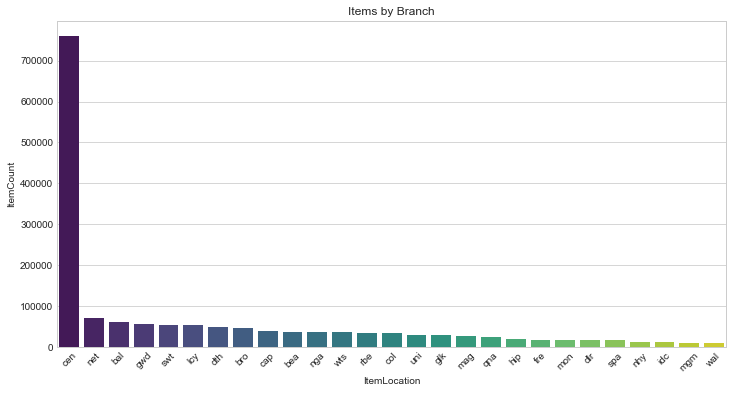

In [55]:
plt.figure(figsize=(12,6))
plt.title('Items by Branch')
plt.xticks(rotation=45)
sns.barplot(x='ItemLocation', y='ItemCount', data=df_loc.reset_index(),palette='viridis');
# plt.savefig('../../docs/images/branches.png')

### What types of materials are in the physical collection? (cat x num)
There are over 1.34 million books and 285,641 media items. DVDs and CDs are the second and third most popular format, respectively. I didn't expect there to be so many music score items. There are almost as many as audio books! It is also very strange to see only two video tapes and five audio tapes exist. Why keep so few?

In [57]:
df_format = df.groupby(by='Format Subgroup')['ItemCount'].sum().sort_values(ascending=False)
print(df_format)
print('\nNon-book',df_format[1:].sum())

Format Subgroup
Book              1344098
Video Disc         152897
Audio Disc          80081
Audiobook Disc      23949
Music Score         19759
Audiobook            8821
Data Disc              65
Document               62
Audio Tape              5
Video Tape              2
Name: ItemCount, dtype: int64

Non-book 285641


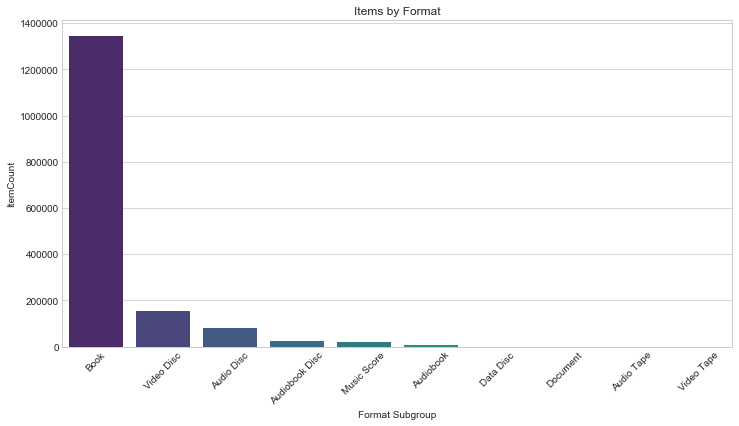

In [59]:
plt.figure(figsize=(12,6))
plt.title('Items by Format')
plt.xticks(rotation=45)
sns.barplot(x='Format Subgroup', y='ItemCount', data=df_format.reset_index(),palette='viridis')
# plt.savefig('../../docs/images/itemsbyformat.png')

In [68]:
# Out of curiosity, here are the only remaing audio and video tapes
df[(df['Format Subgroup']=='Video Tape') | (df['Format Subgroup']=='Audio Tape')]['Title']

117740     Wenn die Sonne sinkt-- [sound recording] / Elf...
140461     La belle Hélène [videorecording] / a ZDF/RM Ar...
149238     Schachnovelle [sound recording] ; Der Amokläuf...
162049                Heroes de la Biblia [sound recording].
714941     Teaching children to read [videorecording] / p...
844936                        Novyĭ Zavet [sound recording].
1320219    Ogonëk [sound recording] : novyĭ ėtap istorii ...
Name: Title, dtype: object

### When were most of the items in the collection published? (cat x num)
From the chart below we can see that most library titles are new. That is, as we get further from the present, the fewer items representing those years there are. This makes sense since the library gets rid of old materials when they become less relevant. It tries to keep up with popular tastes and offer the latest releases. A drawback of setting the PublicationDate null values to the mean age is that now the year 2004 is artificially inflated and it's quite glaring. Another tactic is likely needed to deal with the year nulls.

Note that the last 30 years represent more than 87% of all titles.

In [71]:
df_pubYear = df.groupby(by='PublicationYear')['ItemCount'].sum().\
reset_index().sort_values(by='ItemCount',ascending=False)
print(df_pubYear.head())

     PublicationYear  ItemCount
261             2016     177121
260             2015     151866
262             2017     129279
259             2014     123916
258             2013     111634


In [83]:
print('Last 30 Years: ',df_pubYear['ItemCount'][:30].sum())
print('Total collection: ',df_pubYear['ItemCount'].sum())
print('Last 30 Years percent of total: ',round((df_pubYear['ItemCount'][:30].sum()/df_pubYear['ItemCount'].sum())*100,1))

Last 30 Years:  1420044
Total collection:  1629739
Last 30 Years percent of total:  87.1


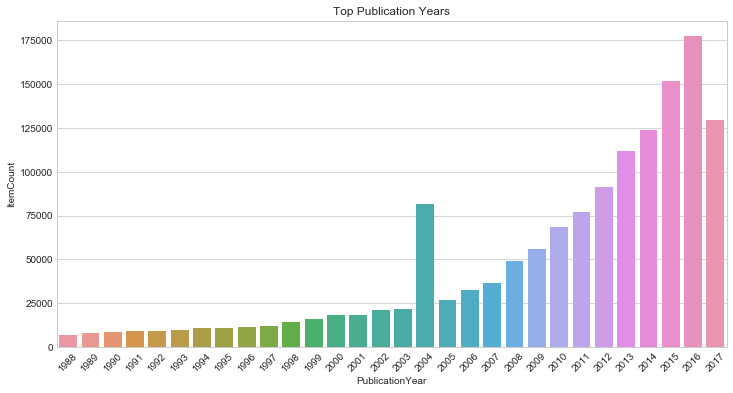

In [84]:
plt.figure(figsize=(12,6))
plt.title('Top Publication Years')
plt.xticks(rotation=45)
sns.barplot(x='PublicationYear',y='ItemCount',data=df_pubYear[:30])
# plt.savefig('../../docs/images/topyears.png')

### What percentage of items are specifically for teens and children?

In [107]:
df.groupby(by='Child')['ItemCount'].sum()[1]
df.groupby(by='Teen')['ItemCount'].sum()[1]
print('Child Items Percent of total: ',round((df.groupby(by='Child')['ItemCount'].sum()[1])/(df['ItemCount'].sum())*100,1),'%')
print('Teen Items Percent of total: ',round((df.groupby(by='Teen')['ItemCount'].sum()[1])/(df['ItemCount'].sum())*100,1),'%')

Child Items Percent of total:  22.8 %
Teen Items Percent of total:  3.9 %


### Are most of the items fiction or nonfiction?
This is an interesting question because there are still a lot of null values that could be assigned to any of these categories.

In [108]:
df.groupby(by='Category Group')['ItemCount'].sum().sort_values(ascending=False).reset_index()

,Category Group,ItemCount
0,Nonfiction,627751
1,Fiction,528997
2,Reference,194385
3,Language,75026


In [111]:
print('Null Category values: ',df['Category Group'].isnull().sum())

Null Category values:  174270


### What are the titles with the most copies?

For Nonfiction, the top title was "SPL HotSpot : connecting Seattle / [distributed by Verizon Wireless]." Further investigation showed that this item has entries across all media types and subtypes. It's clearly not a book or dvd so I removed it from this particular dataframe with a condition.

The most common nonfiction titles are books, with only one documentary DVD appearing in the top 30. Meanwhile the top 30 fiction titles are a pretty even mix of books and DVDs. Notably, the top two books were published the month before the collection dataset was updated. This indicated the library prepares itself for big book releases by having sufficient copies to satisfy demand.

In [116]:
# Top Fiction Books and DVDs
df_fiction = df[(df['Category Group']=='Fiction') & (df['Format Subgroup'].isin(['Book','Video Disc'])) ]\
.groupby(by=['Format Subgroup', 'Title'])['ItemCount'].sum().sort_values(ascending=False).reset_index()[:31]
df_fiction

,Format Subgroup,Title,ItemCount
0,Book,Don't let go / Harlan Coben.,261
1,Book,Five-carat soul / James McBride.,248
2,Video Disc,Arrival / Paramount Pictures ; Filmnation Ente...,245
3,Book,The Underground Railroad : a novel / Colson Wh...,234
4,Video Disc,Moonlight / A24 ; Plan B ; Pastel ; produced b...,210
5,Book,Glass houses / Louise Penny.,207
6,Book,Into the water / Paula Hawkins.,202
7,Book,The ministry of utmost happiness / Arundhati Roy.,199
8,Video Disc,La La Land / Summit Entertainment ; in associa...,198
9,Video Disc,Hidden figures / 20th Century Fox ; Fox 2000 P...,197


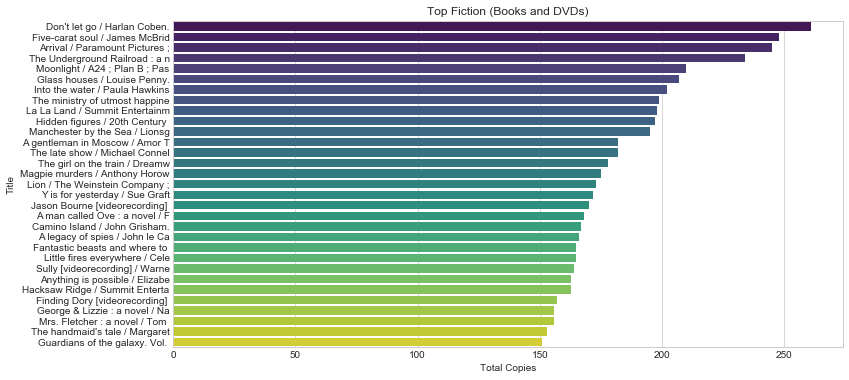

In [117]:
# shorten Title for chart purposes
df_fiction['Title'] = df_fiction['Title'].apply(lambda x:x[:30])
plt.figure(figsize=(12,6))
plt.title('Top Fiction (Books and DVDs)')
ax = sns.barplot(x='ItemCount', y='Title', data=df_fiction, palette='viridis')
ax.set_xlabel('Total Copies')
# plt.savefig('../../docs/images/topfiction.png')

In [121]:
df_nonfiction = df[(df['Category Group']=='Nonfiction') & (df['Format Subgroup'].isin(['Book','Video Disc'])) & (df['BibNum']!=3030520)]\
.groupby(by=['Format Subgroup', 'Title'])['ItemCount'].sum().sort_values(ascending=False).reset_index()[:31]
df_nonfiction

,Format Subgroup,Title,ItemCount
0,Book,Hillbilly elegy : a memoir of a family and cul...,273
1,Book,The sun and her flowers / Rupi Kaur.,244
2,Book,What happened / Hillary Rodham Clinton.,235
3,Book,You don't have to say you love me : a memoir /...,226
4,Book,The World Book encyclopedia.,177
5,Book,The World Book Encyclopedia.,175
6,Book,Born a crime : stories from a South African ch...,173
7,Book,"Al Franken, giant of the Senate / by Al Franken.",166
8,Book,Norse mythology / Neil Gaiman.,163
9,Book,"Option B : facing adversity, building resilien...",155


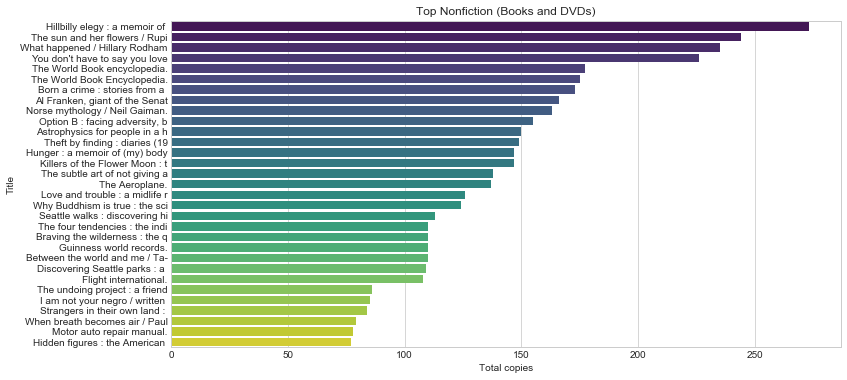

In [122]:
# shorten Title for chart purposes
df_nonfiction['Title'] = df_nonfiction['Title'].apply(lambda x:x[:30])
plt.figure(figsize=(12,6))
plt.title('Top Nonfiction (Books and DVDs)')
ax = sns.barplot(x='ItemCount', y='Title', data=df_nonfiction, palette='viridis')
ax.set_xlabel('Total copies')
# plt.savefig('../../docs/images/topnonfiction.png')

### Who are the top book authors with the most copies in the collection?
Dr. Seuss, the author of beloved children's books, has the most copies.

In [125]:
# Top Authors
df_author = df[df['Format Subgroup']=='Book']\
.groupby(by='Author')['ItemCount'].sum().sort_values(ascending=False).reset_index()[:31]
df_author

,Author,ItemCount
0,"Seuss, Dr.",2778
1,"Willems, Mo",2733
2,"Patterson, James, 1947-",2132
3,"Meadows, Daisy",2047
4,"Stilton, Geronimo",1939
5,United States.,1672
6,"Osborne, Mary Pope",1627
7,"Holm, Jennifer L.",1436
8,"Kertell, Lynn Maslen.",1426
9,"Davis, Jim, 1945 July 28-",1411


### What are the most common CDs in the collection?
We can see that the top CD is the "Jazziz on disc" compilation. The rest of the list is largely current popular music and some artists are perhaps over represented because they are from Seattle ie. Macklemore and Fleet Foxes

In [124]:
# Top CDs
df_audio = df[df['Format Subgroup']=='Audio Disc']\
.groupby(by='Title')['ItemCount'].sum().sort_values(ascending=False).reset_index()[:31]
df_audio

,Title,ItemCount
0,Jazziz on disc. [sound recording],56
1,Melodrama / Lorde.,45
2,Lemonade / Beyoncé.,43
3,We got it from here... thank you 4 your servic...,42
4,Everything now / Arcade Fire.,40
5,Crack-up / Fleet Foxes.,36
6,Hamilton [sound recording] : an American music...,36
7,La La Land : original motion picture soundtrack.,35
8,This unruly mess I've made / Macklemore & Ryan...,35
9,You want it darker / Leonard Cohen.,35


### Who are the top book publishers represented in the collection?
Random house has the most books in the collection but it's interesting to see that some publishers are represented multiple times because of their various imprints. For example, Simon & Schuster has a children's division named Simon & Schuster Books for Young Readers. HarperCollins is the flagship and has many divisions including Harper. It would take further investigation to determine whether duplicates represent different divisions and not input errors.

In [126]:
# Top Publishers
df_pub = df[df['Format Subgroup']=='Book']\
.groupby(by='Publisher')['ItemCount'].sum().sort_values(ascending=False).reset_index()[:31]
df_pub

,Publisher,ItemCount
0,"Random House,",22926
1,"Alfred A. Knopf,",12593
2,"Candlewick Press,",11990
3,"Thorndike Press,",11192
4,"Houghton Mifflin Harcourt,",10713
5,"Simon & Schuster,",9171
6,"Harper,",9010
7,"Little, Brown and Company,",8793
8,"Viking,",8530
9,"Scholastic,",8194


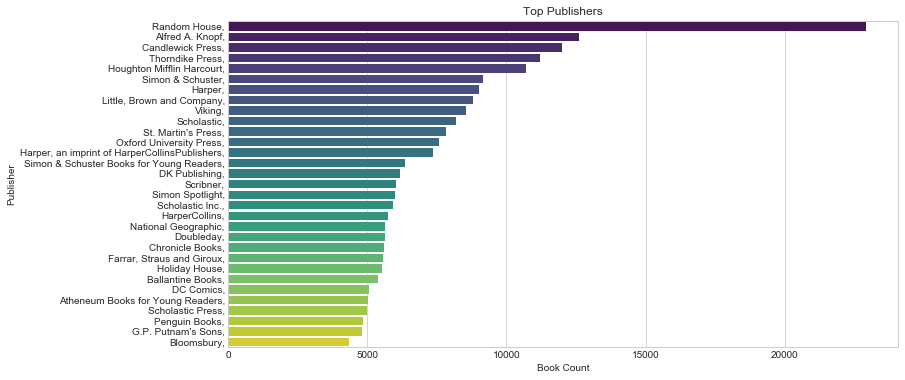

In [127]:
plt.figure(figsize=(12,6))
plt.title('Top Publishers')
ax = sns.barplot(x='ItemCount', y='Publisher', data=df_pub, palette='viridis')
ax.set_xlabel('Book Count')
# plt.savefig('../../docs/images/toppublishers.png')

### Drop unnecessary columns
PublicationYear has been replaced by Age and the Code column is no longer useful.

In [129]:
df.drop(['Code', 'PublicationYear'], axis=1, inplace=True)

### Save new Library collection file
The new file will be used to join with the checkouts file in the next phase.

In [130]:
df.to_csv('../../data/processed/collection.csv',index=False)

### Conclusion
This concludes the Basic EDA of the full inventory collection. While the checkout behaviour and dataset is the main focus, the library catalogue itself merits at least the quick look given here. The resulting processed file from this notebook will be used to join with the checkout dataset. A brief wrangling and a full EDA of the merged datasets will follow.